In [ ]:
# We need to install Detectron2
!apt-get install ninja-build ;
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
# install the model
%cd /notebooks/yolov7
from pathlib import Path

import torch

from models.yolo import Model
from utils.general import check_requirements, set_logging
from utils.google_utils import attempt_download
from utils.torch_utils import select_device

dependencies = ['torch', 'yaml']
check_requirements(Path("/notebooks/yolov7/").parent / '/notebooks/yolov7/requirements.txt', exclude=('pycocotools', 'thop'))
set_logging()

%cd models
!wget "https://huggingface.co/Yolov7/yolov7/resolve/main/yolov7.pt"
!wget "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-mask.pt" 

/notebooks/yolov7
/notebooks/yolov7/models
--2023-09-28 17:43:52--  https://huggingface.co/Yolov7/yolov7/resolve/main/yolov7.pt
Resolving huggingface.co (huggingface.co)... 18.238.49.112, 18.238.49.10, 18.238.49.70, ...
Connecting to huggingface.co (huggingface.co)|18.238.49.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d6/3c/d63cfc38d7e32f5cb5f5b521a8c4e00d4479d3de91d40e782285c3ed0ca6d511/d1ac3c74eb96a3eec77949c0f37a06bc272756606ff011d9353f7abff4e0c71d?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27yolov7.pt%3B+filename%3D%22yolov7.pt%22%3B&Expires=1696182232&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5NjE4MjIzMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kNi8zYy9kNjNjZmMzOGQ3ZTMyZjVjYjVmNWI1MjFhOGM0ZTAwZDQ0NzlkM2RlOTFkNDBlNzgyMjg1YzNlZDBjYTZkNTExL2QxYWMzYzc0ZWI5NmEzZWVjNzc5NDljMGYzN2EwNmJjMjcyNzU2NjA2ZmYwMTFkOTM1M2Y3YWJmZ

In [1]:
import matplotlib.pyplot as plt
import torch
import cv2
import yaml
from torchvision import transforms
import numpy as np

from utils.datasets import letterbox
from utils.general import non_max_suppression_mask_conf

from detectron2.modeling.poolers import ROIPooler
from detectron2.structures import Boxes
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.layers import paste_masks_in_image


In [2]:
%cd /notebooks/yolov7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with open('/notebooks/yolov7/data/hyp.scratch.mask.yaml') as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)
weigths = torch.load('/notebooks/yolov7/models/yolov7-mask.pt')
model = weigths['model']
model = model.half().to(device)
_ = model.eval()

/notebooks/yolov7


In [3]:
image = cv2.imread('/notebooks/Mabillon_Cafe_01.png')  # 504x378 image
image = letterbox(image, 640, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)
image = image.half()

output = model(image)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
inf_out, train_out, attn, mask_iou, bases, sem_output = output['test'], output['bbox_and_cls'], output['attn'], output['mask_iou'], output['bases'], output['sem']

In [5]:
bases = torch.cat([bases, sem_output], dim=1)
nb, _, height, width = image.shape
names = model.names
pooler_scale = model.pooler_scale
pooler = ROIPooler(output_size=hyp['mask_resolution'], scales=(pooler_scale,), sampling_ratio=1, pooler_type='ROIAlignV2', canonical_level=2)

In [6]:
output, output_mask, output_mask_score, output_ac, output_ab = non_max_suppression_mask_conf(inf_out, attn, bases, pooler, hyp, conf_thres=0.25, iou_thres=0.65, merge=False, mask_iou=None)

In [7]:
pred, pred_masks = output[0], output_mask[0]
base = bases[0]
bboxes = Boxes(pred[:, :4])
original_pred_masks = pred_masks.view(-1, hyp['mask_resolution'], hyp['mask_resolution'])
pred_masks = retry_if_cuda_oom(paste_masks_in_image)( original_pred_masks, bboxes, (height, width), threshold=0.5)
pred_masks_np = pred_masks.detach().cpu().numpy()
pred_cls = pred[:, 5].detach().cpu().numpy()
pred_conf = pred[:, 4].detach().cpu().numpy()
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
nbboxes = bboxes.tensor.detach().cpu().numpy().astype(np.int)
pnimg = nimg.copy()

/tmp/ipykernel_674/341959046.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nbboxes = bboxes.tensor.detach().cpu().numpy().astype(np.int)


In [8]:
for one_mask, bbox, cls, conf in zip(pred_masks_np, nbboxes, pred_cls, pred_conf):
    if conf < 0.25:
        continue
    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]
                        
                        
    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5
    pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
    #label = '%s %.3f' % (names[int(cls)], conf)
    #t_size = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]
    #c2 = bbox[0] + t_size[0], bbox[1] - t_size[1] - 3
    #pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), c2, color, -1, cv2.LINE_AA)  # filled
    #pnimg = cv2.putText(pnimg, label, (bbox[0], bbox[1] - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)  
                     

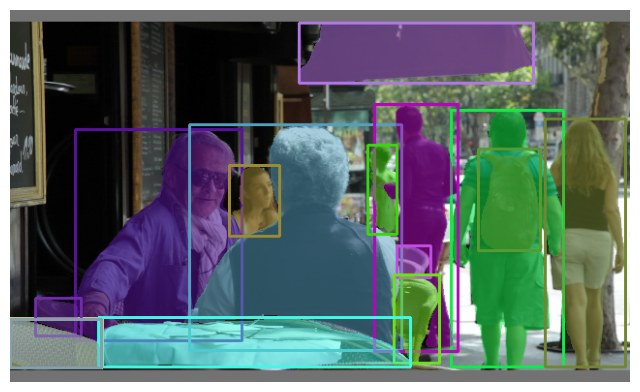

In [9]:
# coco example
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(pnimg)
plt.show()

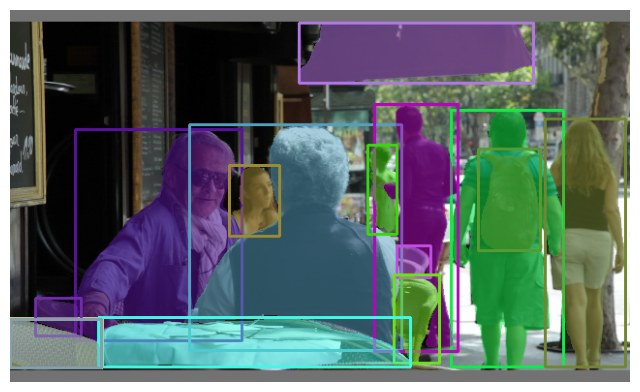

In [10]:
# cityscapes example
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(pnimg)
plt.show()